# Actividad 3 - Regresión Multinomial

Cargamos los datos y los guardamos en la variable _autos_

In [6]:
library(readxl)
if (.Platform$OS.type=="unix"){ ruta_excel <- "datasets/Autos completo.xlsx"
} else ruta_excel <- "../datasets/Autos completo.xlsx"

autos <- read_excel(ruta_excel, sheet="Sheet1")
head(autos, n=3)

Sexo,Edocivil,Edad,Tam,Origen,Tipo
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
Hombre,Casado(a),34,Grande,Americano,Familiar
Hombre,Soltero(a),36,Compacto,Japonés,Deportivo
Hombre,Casado(a),23,Compacto,Japonés,Familiar


Vemos cómo están distribuidos nuestros datos:

In [2]:
# Mujeres
autos_m <- autos[autos$Sexo=="Mujer",]
addmargins(table(autos_m$Tipo, autos_m$Edocivil))

,Casado(a),Soltero(a),Sum
Deportivo,21,20,41
Familiar,58,18,76
Trabajo,16,5,21
Sum,95,43,138


In [3]:
# Hombres
autos_h <- autos[autos$Sexo=="Hombre",]
addmargins(table(autos_h$Tipo, autos_h$Edocivil))

,Casado(a),Soltero(a),Sum
Deportivo,24,35,59
Familiar,61,18,79
Trabajo,16,11,27
Sum,101,64,165


De las tablas anteriores vemos que hay más hombres que mujeres, y que en general hay más autos familiares que de cualquier otro tipo.

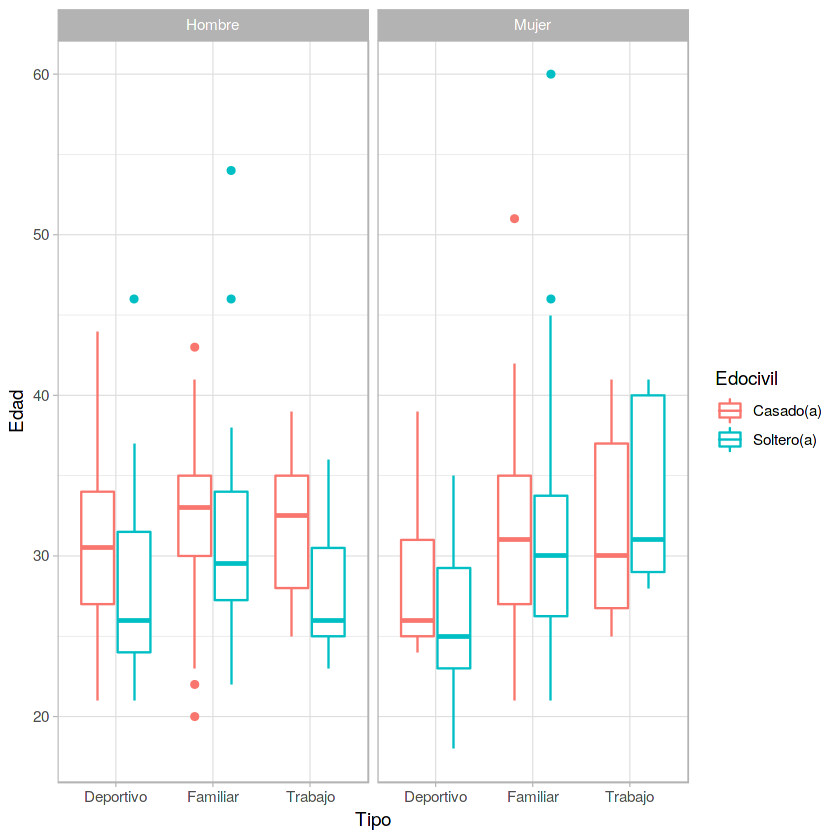

In [4]:
suppressMessages(library(ggplot2))
ggplot(autos, aes(x=Tipo, y=Edad, color=Edocivil)) + 
  geom_boxplot() + theme_light() + facet_grid(.~Sexo)

Del gráfico anterior podemos notar algunas características acerca de la distribución de la muestra:
  - Las mujeres son las que tienen mayor variación en la edad.
  - Hay algunos hombres que compran autos familiares a edad temprana.

Establecemos las categorías de referencia para _Edocivil_, _Sexo_ y _Tipo_:

In [5]:
autos$Edocivil <- relevel(as.factor(autos$Edocivil), ref = "Soltero(a)")
autos$Sexo <- relevel(as.factor(autos$Sexo), ref = "Mujer")
autos$Tipo <- relevel(as.factor(autos$Tipo), ref = "Trabajo")

Calculamos el modelo multinomial saturado:

In [10]:
library(nnet)
library(broom)
suppressMessages(library(dplyr))
autos_mlm_saturado <- multinom(Tipo ~ Edad  * Edocivil * Sexo, data=autos, trace=FALSE)

tidy(autos_mlm_saturado, conf.int = TRUE, conf.level = 0.95, exponentiate = TRUE) %>%
    mutate(
        estimate = round(estimate,4),
        p.value = round(p.value,4),
        conf.low = round(conf.low, 4),
        conf.high = round(conf.high, 4)
    ) %>%
    filter(p.value<=.05)

y.level,term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Deportivo,(Intercept),986.2089,2.56540515,2.6872434,0.0072,6.4609,150537.8596
Deportivo,Edad,0.8278,0.08436468,-2.2404255,0.0251,0.7016,0.9766
Deportivo,EdocivilCasado(a),0.0379,3.28060836,-0.9976327,0.3185,0.0001,23.5007
Deportivo,SexoHombre,0.0026,3.18018437,-1.8670241,0.0619,0.0000,1.3439
Deportivo,Edad:EdocivilCasado(a),1.0800,0.10806389,0.7120829,0.4764,0.8738,1.3348
Deportivo,Edad:SexoHombre,1.2167,0.10703345,1.8327794,0.0668,0.9865,1.5007
Deportivo,EdocivilCasado(a):SexoHombre,118.0536,4.34873891,1.0971316,0.2726,0.0235,593926.4119
Deportivo,Edad:EdocivilCasado(a):SexoHombre,0.8609,0.14356554,-1.0436434,0.2967,0.6497,1.1406
Familiar,(Intercept),6.0707,1.93363683,0.9326860,0.3510,0.1372,268.6299


De las interacciones (filtradas por _p-value_) se obtiene lo siguiente:

  - La asociación entre las categorías _Deportivo_ y _Edad_ es significativa. La razón de momios indica que conforme aumenta la edad, la posibilidad de comprar un automóvil del tipo deportivo disminuye.

Elaboramos la regresión logística multinomial (o politómica) sin interacciones:

In [7]:
library(nnet)
library(broom)
autos_mlm <- multinom(Tipo ~ Edad  + Edocivil + Sexo, data=autos, trace=FALSE)
tidy(autos_mlm, conf.int = TRUE, conf.level = 0.95, exponentiate = TRUE) %>% filter(p.value<=.05)

y.level,term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Deportivo,(Intercept),30.3565720,1.01633395,3.358161,0.000784629,4.1414050,222.5142118
Deportivo,Edad,0.9249815,0.03297969,-2.364533,0.018052800,0.8670830,0.9867460
Deportivo,EdocivilCasado(a),0.4719066,0.37370731,-2.009525,0.044481479,0.2268589,0.9816491


Como vemos hay significancia entre la edad con el tipo de auto deportivo, graficamos las variables Tipo y Edad. También graficamos Tipo y Edo Civil.

De la razón de momios se obtiene lo siguiente:

  - De la razón de momios Deportivo:Edad la posibilidad de que una persona compre un auto deportivo disminuye con la edad, pero no de una manera tan pronunciada.
  - De la razón de momios Deportivo:EdoCivil, vemos que la posibilidad de comprar un auto deportivo disminuye dramáticamente al cambiar de Soltero(a) a Casado(a).

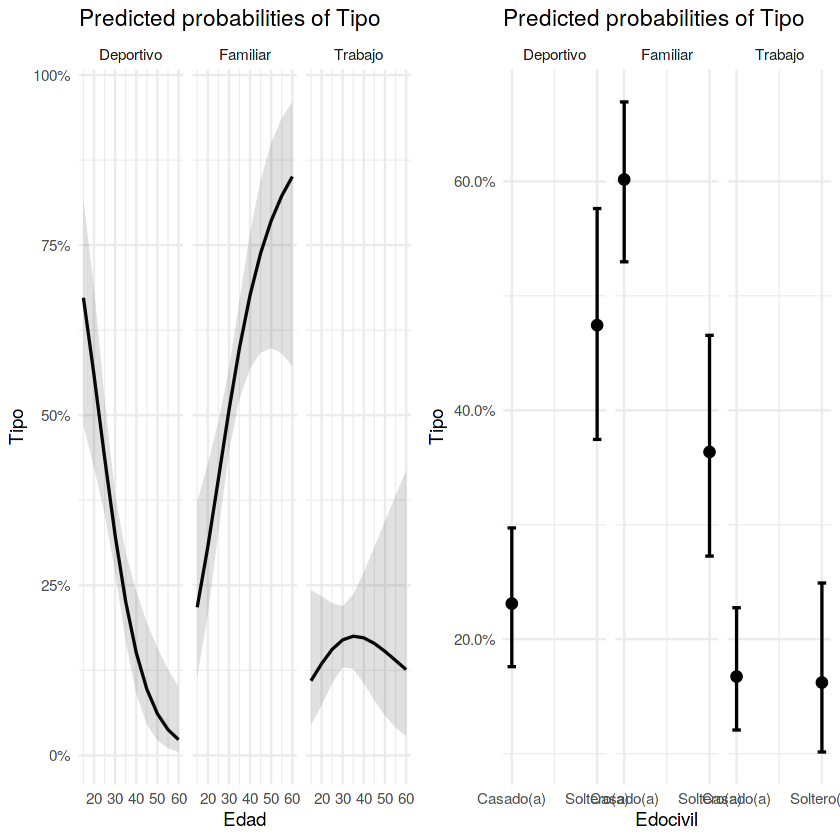

In [8]:
suppressMessages(library(sjPlot))
suppressMessages(library(cowplot))
plot_tipo_edad <- plot_model(autos_mlm, type="eff")$Edad +
    ggplot2::theme_minimal()
plot_tipo_edocivil <-plot_model(autos_mlm, type="eff", wrap.labels=-1)$Edocivil +
    ggplot2::theme_minimal()

plot_grid(plot_tipo_edad,
    plot_tipo_edocivil,    
    label_size = 12,
    ncol=2
)

Hacemos un modelo adicional con la interacción entre Edad y Estado Civil:

In [9]:
library(nnet)
library(broom)
autos_mlm_ee <- multinom(Tipo ~ Edad : Edocivil : Sexo, data=autos, trace=FALSE)
tidy(autos_mlm_ee, conf.int = TRUE, conf.level = 0.95, exponentiate = TRUE)

y.level,term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Deportivo,(Intercept),24.6726213,0.99561502,3.2198130,0.001282742,3.5054700,173.6538166
Deportivo,Edad:EdocivilSoltero(a):SexoMujer,0.9336363,0.03619363,-1.8972477,0.057795258,0.8697004,1.0022725
Deportivo,Edad:EdocivilCasado(a):SexoMujer,0.9051263,0.03441285,-2.8966159,0.003772113,0.8460906,0.9682811
Deportivo,Edad:EdocivilSoltero(a):SexoHombre,0.9347985,0.03446395,-1.9563718,0.050421372,0.8737400,1.0001238
Deportivo,Edad:EdocivilCasado(a):SexoHombre,0.9140355,0.03289585,-2.7324365,0.006286779,0.8569630,0.9749090
Familiar,(Intercept),1.3672967,0.89498458,0.3495430,0.726681723,0.2366195,7.9008718
Familiar,Edad:EdocivilSoltero(a):SexoMujer,1.0282951,0.03144007,0.8874735,0.374824015,0.9668430,1.0936532
Familiar,Edad:EdocivilCasado(a):SexoMujer,1.0307904,0.02931536,1.0344706,0.300916193,0.9732336,1.0917511
Familiar,Edad:EdocivilSoltero(a):SexoHombre,1.0094847,0.03051292,0.3093758,0.757035686,0.9508830,1.0716979


In [2]:
.Platform$OS.type

[1] "unix"